In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

#Importing Classification algorithms

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    SGDClassifier,
    Perceptron,
    PassiveAggressiveClassifier,
    RidgeClassifier, 
    RidgeClassifierCV
)

from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import  GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from rgf.sklearn import RGFClassifier, FastRGFClassifier
from gpboost import GPBoostClassifier
from ngboost import NGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    ExtraTreesClassifier, 
    IsolationForest, 
    BaggingClassifier, 
    HistGradientBoostingClassifier
)

from imblearn.ensemble import (
    EasyEnsembleClassifier, 
    RUSBoostClassifier, 
    BalancedBaggingClassifier, 
    BalancedRandomForestClassifier 
)

from numpy import interp

class Progress:
    def __init__(self, value, end, title='Progress',buffer=100):
        self.title = title
        #when calling in a for loop it doesn't include the last number
        self.end = end 
        self.buffer = buffer
        self.value = value + 1
        self.progress()

    def progress(self):
        maped = int(interp(self.value, [0, self.end], [0, self.buffer]))
        print(f'{self.title}: [{"#"*maped}{"-"*(self.buffer - maped)}]{self.value}/{self.end} {((self.value/self.end)*100):.2f}%', end='\r')

from sklearn import set_config
set_config(display='diagram')        

seed = 42

In [2]:
X_train_pars = pd.read_csv('X_train_pars.csv')
X_test_pars = pd.read_csv('X_test_pars.csv')
TEST_DF_pars = pd.read_csv('TEST_DF_pars.csv')

y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [3]:
train = X_train_pars.append(X_test_pars, ignore_index = True)
target = y_train.append(y_test, ignore_index = True)

sub = pd.read_csv('gender_submission.csv')

In [4]:
#Function for selecting the right model

class classif_models:
    
    def __init__(self, Xtrain, ytrain, preprocessor, cv):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.preprocessor = preprocessor 
        self.cv = cv
        
    def check_clf_models(self):
        
        models = [
            LogisticRegression(random_state = seed),
            LogisticRegressionCV(cv=10, random_state = seed),
            SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            RidgeClassifier(random_state = seed),
            RidgeClassifierCV(cv=10),
            LinearSVC(loss = 'hinge', random_state = seed),
            SVC(kernel = 'rbf', random_state = seed),
            NuSVC(random_state = seed),
            KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
            GaussianNB(), 
            BernoulliNB(),
            MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2, random_state = seed),
            GaussianProcessClassifier(random_state = seed)
        ]
        
        acc = []
        acc_std = []
        f1 = []
        roc_auc = []
        prec = []
        recall = []
        bal_acc = []
        model_names = []
        
        print('Training using Non-Tree based models...')
        for model, i in zip(models, range(len(models))):
            pipe = Pipeline(steps = [('preprocessor', preprocessor), (type(model).__name__, model)])
            
            scores = cross_validate(pipe, 
                                    self.Xtrain, 
                                    self.ytrain,
                                    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall', 
                                               'balanced_accuracy'],
                                    cv = self.cv, 
                                    n_jobs = -1)
            
            acc.append(list(scores.values())[2].mean()*100)
            acc_std.append(list(scores.values())[2].std()*100)
            f1.append(list(scores.values())[3].mean()*100)
            roc_auc.append(list(scores.values())[4].mean()*100)
            prec.append(list(scores.values())[5].mean()*100)
            recall.append(list(scores.values())[6].mean()*100)
            bal_acc.append(list(scores.values())[7].mean()*100)
            
            model_names.append(type(model).__name__)
            Progress(i, len(models))
            
        print()

    #Using Ensemble Models

        tree_models = [
            DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state = seed),
            RandomForestClassifier(criterion='entropy', max_depth=6, class_weight='balanced', n_jobs=-1, random_state = seed), 
            XGBClassifier(use_label_encoder=False, eval_metric = 'error', seed = seed), 
            CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1', random_seed = seed), 
            LGBMClassifier(random_state = seed), 
            AdaBoostClassifier(random_state = seed), 
            GradientBoostingClassifier(random_state = seed), 
            BaggingClassifier(random_state = seed), 
            ExtraTreesClassifier(criterion='entropy', max_depth=6, class_weight='balanced', n_jobs=-1, random_state = seed), 
            HistGradientBoostingClassifier(random_state = seed), 
            EasyEnsembleClassifier(random_state = seed), 
            RUSBoostClassifier(random_state = seed), 
            BalancedBaggingClassifier(random_state = seed), 
            BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6, random_state = seed), 
            RGFClassifier(loss = 'Log', algorithm='RGF_Sib'), 
            FastRGFClassifier(loss='LOGISTIC'),
            GPBoostClassifier(random_state = seed), 
            NGBClassifier(random_state = seed, verbose=False)
        ]
        
        print()
        print('Training Using Ensemble models...')
        for model, i in zip(tree_models, range(len(tree_models))):
            
            scores = cross_validate(model, 
                                    self.Xtrain, 
                                    self.ytrain,
                                    scoring = ['accuracy', 'f1', 'roc_auc', 'precision', 'recall', 
                                               'balanced_accuracy'],
                                    cv = self.cv, 
                                    n_jobs = -1)
            
            acc.append(list(scores.values())[2].mean()*100)
            acc_std.append(list(scores.values())[2].std()*100)
            f1.append(list(scores.values())[3].mean()*100)
            roc_auc.append(list(scores.values())[4].mean()*100)
            prec.append(list(scores.values())[5].mean()*100)
            recall.append(list(scores.values())[6].mean()*100)
            bal_acc.append(list(scores.values())[7].mean()*100)
            
            model_names.append(type(model).__name__)
            Progress(i, len(tree_models))
        
        print()
        self.df = pd.DataFrame({
            'Models': model_names, 
            'Acc %': acc, 
            'Acc STD %': acc_std, 
            'f1 %':f1,
            'ROC_AUC %' :roc_auc, 
            'Precision %': prec,
            'Recall %': recall, 
            'Balanced_Acc %': bal_acc 
        }).sort_values('f1 %', ascending = False, ignore_index = True).style.highlight_max(color = 'green')

        return self.df
    
# classif_models(Xtrain, ytrain, cv)
#.check_clf_models()

In [5]:
X_train_pars

,Pclass,Fare,FamilySize,Title,fare_bin
0,1.140822,90.0000,2.0,1.580189,2.107263
1,0.233532,10.5000,1.0,-1.248735,-0.787846
2,0.233532,13.0000,1.0,-1.248735,0.244044
3,-0.666730,22.0250,3.0,1.580189,-0.052222
4,0.233532,10.5000,1.0,1.580189,-0.787846
...,...,...,...,...,...
663,0.233532,13.8625,1.0,-1.248735,0.011540
664,-0.666730,19.2583,4.0,1.580189,0.011540
665,-0.666730,34.3750,5.0,1.580189,-0.135063
666,1.140822,38.5000,1.0,-1.248735,-0.135063


In [6]:
X_train_pars.columns

Index(['Pclass', 'Fare', 'FamilySize', 'Title', 'fare_bin'], dtype='object')

In [7]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer

preprocessor = StandardScaler()

skf = StratifiedKFold(n_splits = 10, random_state = seed, shuffle = True)

all_models = classif_models(X_train_pars, 
                            y_train, 
                            preprocessor = preprocessor,
                            cv = skf)

all_models.check_clf_models()

Training using Non-Tree based models...
Progress: [####################################################################################################]15/15 100.00%

Training Using Ensemble models...
Progress: [####################################################################################################]18/18 100.00%
Wall time: 1min 37s


,Models,Acc %,Acc STD %,f1 %,ROC_AUC %,Precision %,Recall %,Balanced_Acc %
0,RandomForestClassifier,84.120308,4.348962,79.922583,89.178379,77.855032,82.461538,83.826588
1,ExtraTreesClassifier,83.971054,4.440738,79.805646,88.636380,77.341777,82.815385,83.756705
2,CatBoostClassifier,85.031660,3.050059,79.750308,89.076030,83.015423,76.969231,83.513651
3,BalancedBaggingClassifier,84.276346,2.372187,79.613997,87.614455,78.966688,80.492308,83.573680
4,RGFClassifier,85.332429,4.749329,79.596309,89.034164,84.486797,75.800000,83.532985
5,BalancedRandomForestClassifier,83.523293,3.652361,79.487300,88.486465,76.329852,83.230769,83.479496
6,XGBClassifier,84.579376,2.924961,79.261312,88.251389,81.480612,77.353846,83.218154
7,EasyEnsembleClassifier,82.919493,5.074256,79.021067,87.060431,74.986811,83.953846,83.112231
8,GradientBoostingClassifier,84.427861,4.399961,78.982434,88.868775,81.632459,76.923077,82.999866
9,GPBoostClassifier,84.278607,4.029236,78.908315,88.628795,81.005125,77.369231,82.979040


In [8]:
#for evaluating model

class validate_on_test:
    
    def __init__(self, model, Xtrain, ytrain, Xtest, ytest, cv, beta, optimize):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        self.cv = cv
        self.beta = beta
        self.optimize = optimize
        
        self.Xtrain = self.Xtrain.values
        self.ytrain = self.ytrain[self.ytrain.columns[0]].values
        self.Xtest = self.Xtest.values
        self.ytest = self.ytest[self.ytest.columns[0]].values
        
    def evaluate_model(self):
        
        from texttable import Texttable
        t = Texttable()
        
        if type(self.model).__name__ == 'CalibratedClassifierCV':
            if type(self.model.base_estimator).__name__ == 'Pipeline':
                model_name = 'Cal_' + type(list(self.model.base_estimator.named_steps.items())[1][1]).__name__
            else:
                model_name = 'Cal_' + type(self.model.base_estimator).__name__
        else:
            try: 
                type(list(self.model.named_steps.items())[1][1]).__name__
                
            except AttributeError:
                model_name = type(self.model).__name__
                
            else:
                model_name = type(list(self.model.named_steps.items())[1][1]).__name__
            
        print('+' * len(f' {model_name} '))
        print(f' {model_name} ')
        print('+' * len(f' {model_name} '))
        print()

        print('Performing Cross-Validation...')
        print('------------------------------------------')
        t.set_deco(t.VLINES)
        t.add_rows([['CV#', 'Accuracy %', 'f1 Score %', 'ROC-AUC %']], header = False)
        print(t.draw())
        print('------------------------------------------')
        t.reset()
        t.set_deco(t.HLINES)
        
        thresholds = np.arange(0, 1, 0.001)
        
        # apply threshold to positive probabilities to create labels
        def to_labels(pos_probs, threshold):
            return (pos_probs >= threshold).astype('int64')

        accuracy = []
        f1_score = []
        roc_auc_score = []
        fold_no = 1

        for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain):
            X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index]
            y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index]

            classifier = self.model

            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            y_probs = classifier.predict_proba(X_val_kfold)
           
            accuracy.append(np.round(metrics.accuracy_score(y_val_kfold, y_pred)*100,3))
            f1_score.append(np.round(metrics.f1_score(y_val_kfold, y_pred)*100,3))
            roc_auc_score.append(np.round(metrics.roc_auc_score(y_val_kfold, y_probs[:,1])*100,3))
            
            t.set_cols_align(["c", "c", "c", "c"])
            t.add_row([fold_no, accuracy[fold_no-1],  f1_score[fold_no-1],  roc_auc_score[fold_no-1]])
            print(t.draw())
            t.reset()
        
            fold_no += 1
                
        print()
        print(f'*** {model_name} Mean CV Scores ***')
        print('=' * len(f'*** {model_name} Mean CV Scores ***'))
        print(f'ROC AUC   : {np.mean(roc_auc_score):.3f} ± {np.std(roc_auc_score):.1f} %')
        print(f'f1        : {np.mean(f1_score):.3f} ± {np.std(f1_score):.1f} %')
        print(f'Accuracy  : {np.mean(accuracy):.3f} ± {np.std(accuracy):.1f} %')
        print()
        print("---" * 40)

        y_pred = classifier.predict(self.Xtest)
        y_probs = classifier.predict_proba(self.Xtest)
        
        self.y_probs = y_probs

        print()
        print('====================================')
        print("Classification report on Test set:")
        print('====================================')
        print()
        print(metrics.classification_report(self.ytest, y_pred))
        print()
        print("---" * 40)
        print()
        
        print(f'*** {model_name} scores on TEST set ***')
        print('=' * len(f'*** {model_name} scores on TEST set ***'))
        print(f'ROC AUC   : {metrics.roc_auc_score(self.ytest, y_probs[:,1])*100:.4f} %')
        print(f'f1        : {metrics.f1_score(self.ytest, y_pred)*100:.4f} %')
        print(f'Accuracy  : {metrics.accuracy_score(self.ytest, y_pred)*100:.4f} %')
        print()
        
        print("---" * 40)
        
        if self.beta == 'auto':
            if self.optimize == 'fbeta':
                beta_array = np.arange(0.5,2.05,0.05)

                # evaluate each threshold
                beta_val_array = []
                best_f1 = []
                best_threshold = []
                best_acc = []
                print()
                print('Estimating New Probability Threshold...')

                for b, i in zip(beta_array, range(len(beta_array))):

                    beta_val_array.append(b)

                    fbeta_score = [metrics.fbeta_score(self.ytest, 
                                                       to_labels(self.y_probs[:,1], t), 
                                                       beta = b) for t in thresholds]

                    acc = [metrics.accuracy_score(self.ytest,
                                                  to_labels(self.y_probs[:,1], t)) for t in thresholds]
                    
                    ix = np.argmax(fbeta_score)
                        
                    best_f1.append(fbeta_score[ix])
                    best_acc.append(acc[ix])
                    best_threshold.append(thresholds[ix])

                    Progress(i, len(beta_array))
            
                print()
                score_df = pd.DataFrame({
                    'threshold': best_threshold,
                    'Beta' : beta_val_array,
                    'fbeta': best_f1, 
                    'accuracy' : best_acc
                }).sort_values(self.optimize, ascending = False, ignore_index = True)

                self.score_df = score_df
                
                print()
                print('Best F-beta, Accuracy, Beta & Threshold:')
                print('========================================')
                print(f'Beta      : {score_df.iloc[0, 1]:.2f}')
                print(f'Threshold : {score_df.iloc[0, 0]*100:.2f} %')
                print(f'F-beta    : {score_df.iloc[0, 2]*100:.4f} %')
                print(f'Accuracy  : {score_df.iloc[0, 3]*100:.4f} %')
                print()
                
                thresh_val = score_df.iloc[0,0]
                self.tuned_pred = np.where(self.y_probs[:,1] >= thresh_val, 1, 0).astype('int64')
                self.new_prob_threshold = thresh_val
                
                plot_df = pd.DataFrame({
                    'threshold' : thresholds, 
                    'fbeta' : [metrics.fbeta_score(self.ytest,
                                                   to_labels(self.y_probs[:,1], t),
                                                   beta = score_df.iloc[0, 1]) for t in thresholds], 
                    'accuracy': acc
                })
                
            else:
                fbeta_score = [metrics.fbeta_score(self.ytest, 
                                                       to_labels(self.y_probs[:,1], t), 
                                                       beta = 1) for t in thresholds]
                
                acc = [metrics.accuracy_score(self.ytest,
                                                  to_labels(self.y_probs[:,1], t)) for t in thresholds]
                
                ix = np.argmax(acc)
                
                score_df = pd.DataFrame({
                    'threshold': thresholds,
                    'fbeta': fbeta_score, 
                    'accuracy' : acc
                }).sort_values(self.optimize, ascending = False, ignore_index = True)

                self.score_df = score_df
                plot_df = score_df
            
                print()
                print('Best F1, Accuracy, & Threshold:')
                print('===============================')
                print(f'Threshold : {score_df.iloc[0, 0]*100:.2f} %')
                print(f'F1        : {score_df.iloc[0, 1]*100:.4f} %')
                print(f'Accuracy  : {score_df.iloc[0, 2]*100:.4f} %')
                print()
                
                thresh_val = score_df.iloc[0, 0]
                self.tuned_pred = np.where(self.y_probs[:,1] >= thresh_val, 1, 0).astype('int64')
                self.new_prob_threshold = thresh_val
            
        else:
            beta_val = self.beta

            # evaluate each threshold
            fbeta_score = [metrics.fbeta_score(self.ytest, 
                                               to_labels(self.y_probs[:,1], t), 
                                               beta = beta_val) for t in thresholds]
            
            acc = [metrics.accuracy_score(self.ytest,
                                          to_labels(self.y_probs[:,1], t)) for t in thresholds]
                    
            score_df = pd.DataFrame({
                'threshold': thresholds,
                'fbeta': fbeta_score, 
                'accuracy' : acc
            }).sort_values(self.optimize, ascending = False, ignore_index = True)
            
            self.score_df = score_df
            plot_df = score_df
            
            print('Best F-beta, Accuracy, Beta & Threshold:')
            print('========================================')
            print(f'Beta      : {self.beta}')
            print(f'Threshold : {score_df.iloc[0,0]*100:.4f} %')
            print(f'F-beta    : {score_df.iloc[0,1]*100:.4f} %')
            print(f'Accuracy  : {score_df.iloc[0,2]*100:.4f} %')
            print()
            
            thresh_val = score_df.iloc[0,0]
            self.new_prob_threshold = thresh_val
            self.tuned_pred = np.where(self.y_probs[:,1] >= thresh_val, 1, 0).astype('int64')
            
        print("---" * 40)
        
        print('=================================================================================')
        print(' Threshold-Tuning Curve, ROC-AUC Plot, Precision-Recall Curve & Confusion Matrix ')
        print('=================================================================================')
        
        #All Train set
        
        train_probs = classifier.predict_proba(self.Xtrain)
        
        all_f = []
        all_acc = []
        
        for t, i in zip(thresholds, range(len(thresholds))):
            all_f.append(metrics.f1_score(self.ytrain, 
                                          to_labels(train_probs[:,1], t)))
            
            all_acc.append(metrics.accuracy_score(self.ytrain, 
                                                  to_labels(train_probs[:,1], t)))
            
            Progress(i, len(thresholds))
        
        print()
        
        fig = plt.figure(figsize = (11.5,5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        #Train set
        sns.lineplot(x = thresholds, y = all_f, ax = ax1, label = 'Train F1 scores').\
            set_title('Threshold for Max F-score');
        
        ax1.axvline(thresholds[np.argmax(all_f)], color = 'red', linestyle = '--', 
           lw = 2, label = f'Train Thresh = {thresholds[np.argmax(all_f)]*100:.2f} %');
        
        sns.lineplot(x = thresholds, y = all_acc, ax = ax2, label = 'Train Accuracy').\
            set_title('Threshold for Max Accuracy');
        
        ax2.axvline(thresholds[np.argmax(all_acc)], color = 'red', linestyle = '--', 
           lw = 2, label = f'Train Thresh = {thresholds[np.argmax(all_acc)]*100:.2f} %');

        plt.tight_layout();
        
        #Test set
        f_df = plot_df.sort_values('fbeta', ascending = False, ignore_index = True)
        acc_df = plot_df.sort_values('accuracy', ascending = False, ignore_index = True)
        
        sns.lineplot(x = 'threshold', y = 'fbeta', data = plot_df, 
                     label = 'Test F-score', ax = ax1).set_title('Threshold for Max F-score');
        
        ax1.axvline(f_df.iloc[0,0], color = 'black', linestyle = '--', 
                   label = f' Test F-score Thresh = {f_df.iloc[0,0]*100:.2f} %');
        
        ax1.legend(loc='lower right');
        
        sns.lineplot(x = 'threshold', y = 'accuracy', data = plot_df, 
                     label = 'Test Accuracy', ax = ax2).set_title('Threshold for Max Accuracy');
        
        ax2.axvline(acc_df.iloc[0,0], color = 'black', linestyle = '--', 
                   label = f' Test Accuracy Thresh = {acc_df.iloc[0,0]*100:.2f} %');

        ax2.legend(loc='lower right');
        plt.tight_layout()
        
        #roc-auc, precision-recall curve
        fig = plt.figure(figsize = (13,4.5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        #roc curve
        fpr, tpr, thresh = metrics.roc_curve(self.ytest, y_probs[:,1])
        J = tpr - fpr
        ix = np.argmax(J)

        ax1.plot([0,1], [0,1], linestyle='--', label='No Skill')
        ax1.plot(fpr, tpr, marker='.', 
                 label=f'roc-auc = {metrics.roc_auc_score(self.ytest, y_probs[:,1])*100:.2f} %')
        
        ax1.scatter(fpr[ix], tpr[ix], marker='o', color='black', 
                    label=f'Best threshold = {thresh[ix]*100:.2f} %')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend();
        
        #precision-recall curve
        precision, recall, thresh = metrics.precision_recall_curve(self.ytest, y_probs[:,1])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        ax2.plot(recall, precision, marker='.', label=f'F1 Score = {fscore[ix]*100:.2f} %')
        ax2.scatter(recall[ix], precision[ix], marker='o', color='black', 
                       label=f'Best Thresh = {thresh[ix]*100:.2f} %')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend()

        #Confusion Matrix
        fig = plt.figure(figsize = (13,4));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        skplt.metrics.plot_confusion_matrix(self.ytest, y_pred, ax = ax1, text_fontsize = 'large', 
                                            cmap='YlGn');
    
        
        skplt.metrics.plot_confusion_matrix(self.ytest, self.tuned_pred, ax = ax2, text_fontsize = 'large',
                                            cmap='YlGn');
        
        ax1.title.set_text('With Prob. Threshold = 50 %');
        ax2.title.set_text(f'With New Prob. Threshold = {thresh_val*100:.2f} %');
        
# validate_on_test(model, Xtrain, ytrain, Xtest, ytest, cv, beta = 'auto', optimize = 'fbeta')
#.evaluate_model()

In [9]:
class calibrate_model:
    
    def __init__(self, model, Xtrain, ytrain, Xtest, ytest, cv):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        self.cv = cv
        
        self.Xtrain = self.Xtrain.values
        self.ytrain = self.ytrain[self.ytrain.columns[0]].values
        self.Xtest = self.Xtest.values
        self.ytest = self.ytest[self.ytest.columns[0]].values
        
    def calibrate_probability(self):
        
        from sklearn.model_selection import train_test_split
        from sklearn.calibration import CalibratedClassifierCV
        from sklearn.calibration import calibration_curve
        
        train_X, val_X, train_y, val_y = train_test_split(self.Xtrain, 
                                                          self.ytrain, 
                                                          test_size = 0.2, 
                                                          random_state = seed)
        
        
        #uncalibrated model
        
        for train_index, test_index in self.cv.split(train_X, train_y): 
            X_train_kfold, X_val_kfold = train_X[train_index], train_X[test_index] 
            y_train_kfold, y_val_kfold = train_y[train_index], train_y[test_index] 
            self.model.fit(X_train_kfold, y_train_kfold)
            
        uc_probs = self.model.predict_proba(self.Xtest)[:, 1]
        uc_fop, uc_mpv = calibration_curve(self.ytest, uc_probs, n_bins=10, normalize=True, 
                                           strategy = 'quantile')
        
        print()
        print(f'Model: {type(self.model).__name__}')
        print()
        print(f'Uncalibrated Brier Score: {metrics.brier_score_loss(self.ytest, uc_probs):.4f}')
        print(f'Uncalibrated ROC-AUC: {metrics.roc_auc_score(self.ytest, uc_probs)*100:.3f}')
    

        #Calibrating Sigmoid Model
        self.sigmoid_cal_model = CalibratedClassifierCV(self.model, method='sigmoid', cv=self.cv)
        self.sigmoid_cal_model.fit(val_X, val_y)
        
        # predict probabilities
        c_sig_probs = self.sigmoid_cal_model.predict_proba(self.Xtest)[:, 1]
        
        print()
        print(f'Calibrated Sigmoid ROC-AUC: {metrics.roc_auc_score(self.ytest, c_sig_probs)*100:.3f} %')
        print()
        
        #Calibrating isotonic Model
        self.isotonic_cal_model = CalibratedClassifierCV(self.model, method='isotonic', cv=self.cv)
        self.isotonic_cal_model.fit(val_X, val_y)
        
        # predict probabilities
        c_iso_probs = self.isotonic_cal_model.predict_proba(self.Xtest)[:, 1]
        
        print(f'Calibrated isotonic ROC-AUC: {metrics.roc_auc_score(self.ytest, c_iso_probs)*100:.3f} %')
        print()
        
        fig = plt.figure(figsize = (12,5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        # reliability diagram for sigmoid
        c_fop, c_mpv = calibration_curve(self.ytest, c_sig_probs, n_bins=10, normalize=True,
                                         strategy = 'quantile')

        # plot calibrated
        ax1.plot([0, 1], [0, 1], linestyle='--');

        # plot un calibrated model reliability 
        ax1.plot(uc_mpv, uc_fop, marker='.', label = 'Uncalibrated');

        # plot calibrated reliability
        ax1.plot(c_mpv, c_fop, marker='.', 
                 label = f'Brier Score = {metrics.brier_score_loss(self.ytest, c_sig_probs):.4f}');

        ax1.set_title('Calibration using Sigmoid')
        ax1.set_ylabel('Fraction of Positives (fop)')
        ax1.set_xlabel('Mean Predicted Value (mpv)')
        ax1.legend();
        plt.tight_layout()
        
        # reliability diagram for isotonic
        c_fop, c_mpv = calibration_curve(self.ytest, c_iso_probs, n_bins=10, normalize=True,
                                         strategy = 'quantile')

        # plot CATBOOST calibrated
        ax2.plot([0, 1], [0, 1], linestyle='--');

        # plot un calibrated model reliability 
        ax2.plot(uc_mpv, uc_fop, marker='.', label = 'Uncalibrated');

        # plot calibrated reliability
        ax2.plot(c_mpv, c_fop, marker='.', 
                 label = f'Brier Score = {metrics.brier_score_loss(self.ytest, c_iso_probs):.4f}');

        ax2.set_title('Calibration using Isotonic')
        ax2.set_ylabel('Fraction of Positives (fop)')
        ax2.set_xlabel('Mean Predicted Value (mpv)')
        ax2.legend();
        
        plt.tight_layout()
        
        plt.show()
#calibrate_model(model, Xtrain, ytrain, Xtest, ytest, cv)
#.calibrate_probability()

In [10]:
class predict_unseen_data:
    def __init__(self, model, Xtrain, ytrain, Xtest, cv, set_threshold = 0.5):
        self.model = model
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.cv = cv
        self.set_threshold = set_threshold
        
        self.Xtrain = self.Xtrain.values
        self.ytrain = self.ytrain[self.ytrain.columns[0]].values
        self.Xtest = self.Xtest.values
        
    def prediction(self):
        from texttable import Texttable
        t = Texttable()
        
        if type(self.model).__name__ == 'CalibratedClassifierCV':
            if type(self.model.base_estimator).__name__ == 'Pipeline':
                model_name = 'Cal_' + type(list(self.model.base_estimator.named_steps.items())[1][1]).__name__
            else:
                model_name = 'Cal_' + type(self.model.base_estimator).__name__
        else:
            try: 
                type(list(self.model.named_steps.items())[1][1]).__name__
                
            except AttributeError:
                model_name = type(self.model).__name__
                
            else:
                model_name = type(list(self.model.named_steps.items())[1][1]).__name__
            
        print('+' * len(f' {model_name} '))
        print(f' {model_name} ')
        print('+' * len(f' {model_name} '))
        print()

        print('Performing Cross-Validation...')
        print('------------------------------------------')
        t.set_deco(t.VLINES)
        t.add_rows([['CV#', 'Accuracy %', 'f1 Score %', 'ROC-AUC %']], header = False)
        print(t.draw())
        print('------------------------------------------')
        t.reset()
        t.set_deco(t.HLINES)
        
        # apply threshold to positive probabilities to create labels
        thresholds = np.arange(0, 1, 0.001)
        
        # apply threshold to positive probabilities to create labels
        def to_labels(pos_probs, threshold):
            return (pos_probs >= threshold).astype('int64')

        accuracy = []
        f1_score = []
        roc_auc_score = []
        fold_no = 1
        
        for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain):
            X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index]
            y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index]

            classifier = self.model

            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            y_probs = classifier.predict_proba(X_val_kfold)
            
            accuracy.append(np.round(metrics.accuracy_score(y_val_kfold, y_pred)*100,3))
            f1_score.append(np.round(metrics.f1_score(y_val_kfold, y_pred)*100,3))
            roc_auc_score.append(np.round(metrics.roc_auc_score(y_val_kfold, y_probs[:,1])*100,3))
            
            t.set_cols_align(["c", "c", "c", "c"])
            t.add_row([fold_no, accuracy[fold_no-1],  f1_score[fold_no-1],  roc_auc_score[fold_no-1]])
            print(t.draw())
            t.reset()
            
            fold_no += 1
        
        print()
        
        train_preds = classifier.predict_proba(self.Xtrain)
        
        all_f = []
        all_acc = []
        
        for t, i in zip(thresholds, range(len(thresholds))):
            all_f.append(metrics.f1_score(self.ytrain, 
                                          to_labels(train_preds[:,1], t)))
            
            all_acc.append(metrics.accuracy_score(self.ytrain, 
                                                  to_labels(train_preds[:,1], t)))
            
            Progress(i, len(thresholds))
            
        print()
    
        fig = plt.figure(figsize = (12,5));
        ax1 = fig.add_subplot(121);
        ax2 = fig.add_subplot(122);
        
        #F1
        sns.lineplot(x = thresholds, y = all_f, ax = ax1).set_title('Threshold for Max F-score');
        
        ax1.axvline(thresholds[np.argmax(all_f)], color = 'red', linestyle = '--', 
           lw = 2, label = f'Train Thresh = {thresholds[np.argmax(all_f)]*100:.2f} %');

        ax1.legend(loc='upper right');
        
        #Accuracy
        sns.lineplot(x = thresholds, y = all_acc, ax = ax2).set_title('Threshold for Max Accuracy');
        
        ax2.axvline(thresholds[np.argmax(all_acc)], color = 'red', linestyle = '--', 
           lw = 2, label = f'Train Thresh = {thresholds[np.argmax(all_acc)]*100:.2f} %');

        ax2.legend(loc='upper right');
        plt.tight_layout();
        
        print()
        print(f'*** {model_name} Mean CV Scores ***')
        print('=' * len(f'*** {model_name} Mean CV Scores ***'))
        print(f'ROC AUC   : {np.mean(roc_auc_score):.3f} ± {np.std(roc_auc_score):.1f} %')
        print(f'f1        : {np.mean(f1_score):.3f} ± {np.std(f1_score):.1f} %')
        print(f'Accuracy  : {np.mean(accuracy):.3f} ± {np.std(accuracy):.1f} %')
        print()
        print("---" * 40)

        self.thresh_val = self.set_threshold
        print()
        print(f'Chosen Probability Threshold: {self.thresh_val*100:.2f} %')
        
        self.y_probs = classifier.predict_proba(self.Xtest)[:,1]
        self.final_pred =  np.where(self.y_probs >= self.thresh_val, 1, 0)
        
        print()
        print('Finish!')
        
#predict_unseen_data(model, Xtrain, ytrain, Xtest, cv, set_threshold = 0.5)
#.prediction()

# Hyperparameter Tuning

## RandomForest

Best Accuracy: -79.77879691687741 %
Best parameters:
n_estimators=735, 
criterion='gini',
max_depth=6,
min_samples_split=0.00010, 
min_samples_leaf=1, 
max_features='sqrt', 
ccp_alpha=0.00010, 
bootstrap=True, 
class_weight='balanced' 

Wall time: 10min 38s


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

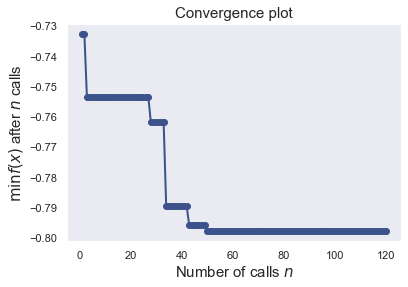

In [12]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical #Real = float
from skopt.utils import use_named_args

param_grid = [
    Integer(100, 1000, name="n_estimators"),
    Categorical(['gini', 'entropy'], name = "criterion"),
    Integer(1,6, name = "max_depth"),
    Real(0.0001, 0.999, name = "min_samples_split"),
    Integer(1,30, name = "min_samples_leaf"),
    Categorical(['sqrt', 'log2'], name = "max_features"),
    Real(0.0001, 0.035, name="ccp_alpha"),
    Categorical([True], name = "bootstrap"),
    Categorical(['balanced', 'balanced_subsample'], name = "class_weight")
]

model = RandomForestClassifier(random_state = seed, n_jobs = -1)

@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    model.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(cross_val_score(model, X_train_pars, y_train,
                                    cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True),
                                    n_jobs=-1, scoring='f1')
                   )

    # negate because we need to minimize
    return -value

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=20, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=120, # the number of subsequent evaluations of f(x)
    random_state=seed, 
    n_jobs=-1,
)

print(f'Best Accuracy: {gp_.fun*100} %')  

print(f"""Best parameters:
=========================
n_estimators={gp_.x[0]}, 
criterion='{gp_.x[1]}',
max_depth={gp_.x[2]},
min_samples_split={gp_.x[3]:.5f}, 
min_samples_leaf={gp_.x[4]}, 
max_features='{gp_.x[5]}', 
ccp_alpha={gp_.x[6]:.5f}, 
bootstrap={gp_.x[7]}, 
class_weight='{gp_.x[8]}' """) 
print()

plot_convergence(gp_);

++++++++++++++++++++++++
 RandomForestClassifier 
++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.075       80.769      94.325  
 2      88.060       84.615      86.492  
 3      91.045       88.462      89.916  
 4      79.104         72        82.598  
 5      85.075         80        90.947  
 6      80.597       77.193      91.745  
 7      82.090         76        81.857  
 8      91.045       88.889      94.429  
 9      75.758       71.429      87.317  
10      83.333       78.431      89.024  

*** RandomForestClassifier Mean CV Scores ***
ROC AUC   : 88.865 ± 4.1 %
f1        : 79.779 ± 5.8 %
Accuracy  : 84.118 ± 4.7 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

   

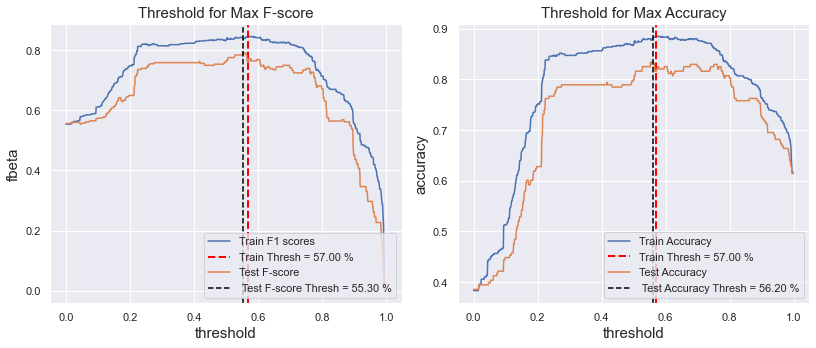

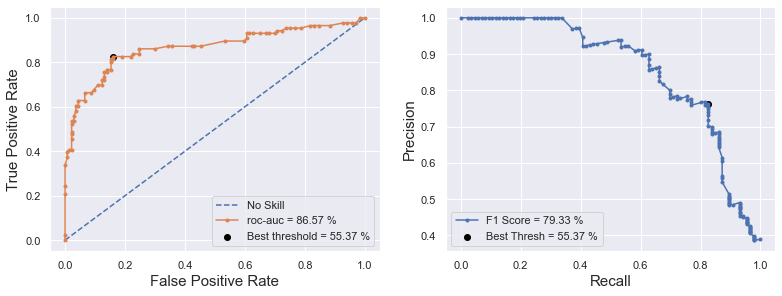

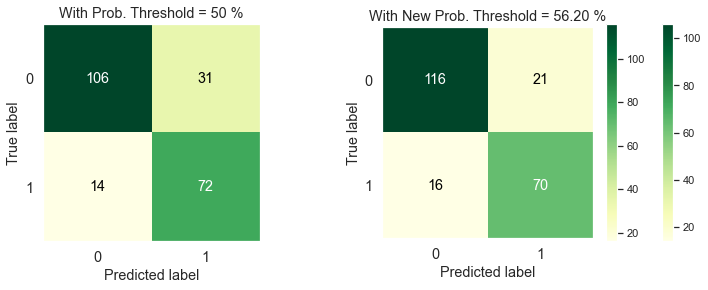

In [13]:
%%time
rf = RandomForestClassifier(
    random_state = seed,
    n_estimators=735, 
    criterion='gini',
    max_depth=6,
    min_samples_split=0.00010, 
    min_samples_leaf=1, 
    max_features='sqrt', 
    ccp_alpha=0.00010, 
    bootstrap=True, 
    class_weight='balanced'
)

rf_val = validate_on_test(rf, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

rf_val.evaluate_model()

++++++++++++++++++++++++
 RandomForestClassifier 
++++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      82.222       78.947      87.766  
 2      78.652       73.973      87.011  
 3      83.146       79.452      88.422  
 4      78.652       70.769      87.005  
 5      86.517       82.353      91.658  
 6      84.270       80.556      89.920  
 7      86.517       82.857      91.551  
 8      82.022         75        84.465  
 9      84.270         80        92.406  
10      83.146       78.261      87.995  

Progress: [####################################################################################################]1000/1000 100.00%

*** RandomForestClassifier Mean CV Scores ***
ROC AUC   : 88.820 ± 2.4 %
f1        : 78.217 ± 3.6 %
Accuracy  : 82.941 ± 2.6 %

-------------------------------------------------------------------------------------

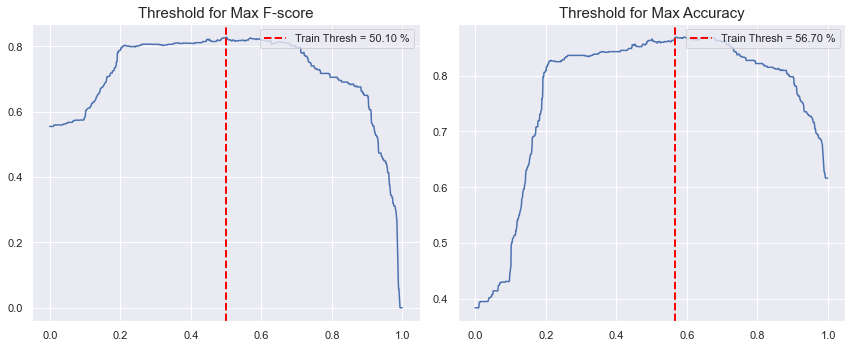

In [18]:
%%time

rf_pred = predict_unseen_data(rf, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.5670)

rf_pred.prediction()

sub.Survived = rf_pred.final_pred
sub.to_csv('new_rf_1.csv', index = False)

#score = 77%

# CatBoost

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [12:58<00:00,  6.49s/trial, best loss: -0.8035138887651734]

Best Params: {'boosting_type': 0, 'border_count': 63.998863361912775, 'depth': 6.0, 'iterations': 600.0, 'l2_leaf_reg': 68.42287334141068, 'learning_rate': 0.11921512437631746}

Wall time: 13min 8s


Text(0.5, 1.0, 'TPE Search')

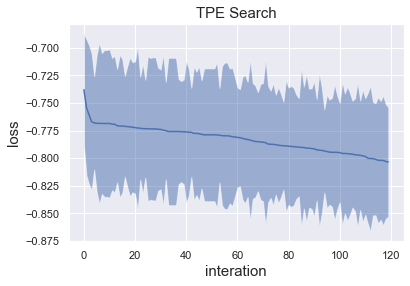

In [20]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL
from catboost import CatBoostClassifier

param_grid = {
    'iterations': hp.quniform('iterations', 200, 1000, 25),
    'depth': hp.quniform('depth', 1, 7, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1)),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1.0, 100.0),
    'border_count': hp.loguniform('border_count', np.log(5), np.log(200))
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'iterations': int(params['iterations']),
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'boosting_type': params['boosting_type'],
        'l2_leaf_reg': params['l2_leaf_reg'],
        'border_count': int(params['border_count']) 
    }

    # with ** we pass the items in the dictionary as parameters
    
    cat = CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1', 
                             random_seed = seed)
    
    model = cat.set_params(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=120,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [21]:
def create_param_grid(search, boosting_type):
    best_hp_dict = {
        'iterations': int(search['iterations']),
        'depth': int(search['depth']),
        'learning_rate': search['learning_rate'],
        'boosting_type': boosting_type,
        'l2_leaf_reg': search['l2_leaf_reg'],
        'border_count': int(search['border_count'])
    }
    return best_hp_dict

cat_param = create_param_grid(tpe_search, 'Ordered')
print(cat_param)

{'iterations': 600, 'depth': 6, 'learning_rate': 0.11921512437631746, 'boosting_type': 'Ordered', 'l2_leaf_reg': 68.42287334141068, 'border_count': 63}


++++++++++++++++++++
 CatBoostClassifier 
++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      88.060       83.333      93.011  
 2      88.060       82.609      86.210  
 3      92.537       90.196      91.792  
 4      82.090         75        82.411  
 5      82.090       73.913      91.276  
 6      80.597       76.364      89.587  
 7      82.090         75        83.952  
 8      88.060       84.615      94.190  
 9      86.364       81.633      88.390  
10      86.364       80.851      91.171  

*** CatBoostClassifier Mean CV Scores ***
ROC AUC   : 89.199 ± 3.7 %
f1        : 80.351 ± 5.0 %
Accuracy  : 85.631 ± 3.6 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           0       

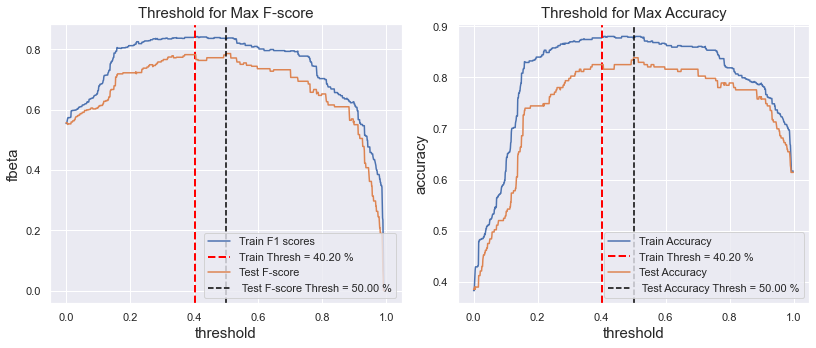

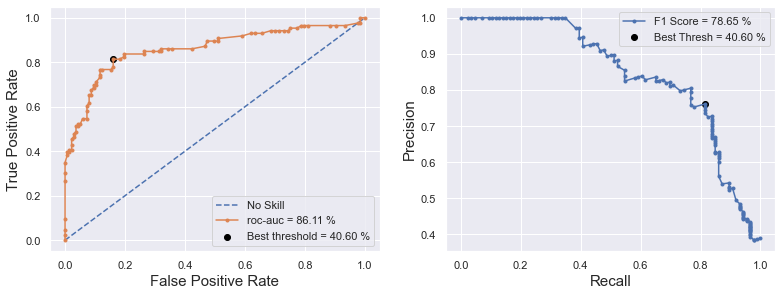

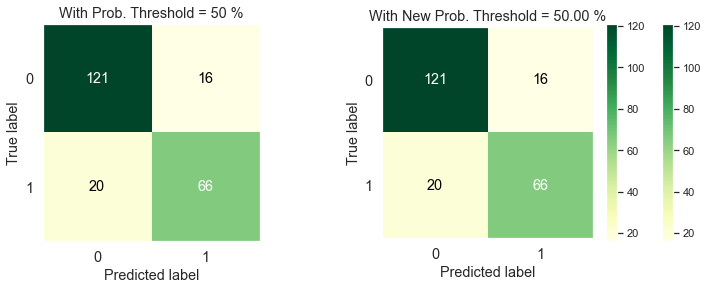

In [23]:
%%time
model = CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1', 
                             random_seed = seed)

cat = model.set_params(**cat_param)

cat_val = validate_on_test(cat, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

cat_val.evaluate_model()

++++++++++++++++++++
 CatBoostClassifier 
++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      83.333       78.873      88.416  
 2      84.270       79.412      86.217  
 3      84.270       78.125      87.674  
 4      79.775         70        86.337  
 5      85.393         80        89.840  
 6      84.270       78.788      88.690  
 7      91.011       87.879      92.139  
 8      78.652       67.797      84.893  
 9      84.270       78.788      91.524  
10      83.146       75.410      87.193  

Progress: [####################################################################################################]1000/1000 100.00%

*** CatBoostClassifier Mean CV Scores ***
ROC AUC   : 88.292 ± 2.2 %
f1        : 77.507 ± 5.3 %
Accuracy  : 83.839 ± 3.1 %

-----------------------------------------------------------------------------------------------------

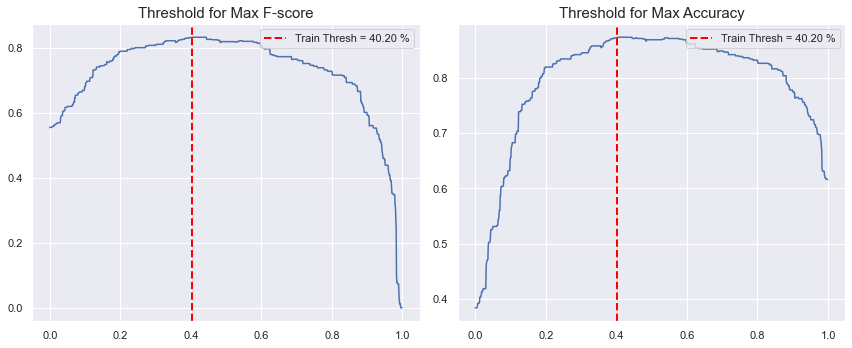

In [25]:
%%time

cat_pred = predict_unseen_data(cat, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.4020)

cat_pred.prediction()

sub.Survived = cat_pred.final_pred
sub.to_csv('new_cat_1.csv', index = False)

#score = 76.79 %

# RGF

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [28:45<00:00, 14.38s/trial, best loss: -0.8040602217033719]

Best Params: {'algorithm': 1, 'calc_prob': 0, 'l2': 0.5523838562552357, 'learning_rate': 0.07855455606959709, 'loss': 0, 'max_leaf': 4531.458023367242, 'min_samples_leaf': 12.864818462440605, 'reg_depth': 1.426141861306805, 'test_interval': 307.3409401330696}

Wall time: 28min 45s


Text(0.5, 1.0, 'TPE Search')

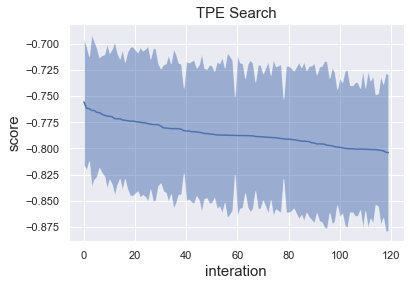

In [26]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL


param_grid = {
    'algorithm':  hp.choice('algorithm', ['RGF', 'RGF_Opt', 'RGF_Sib']),
    'calc_prob': hp.choice('calc_prob', ["softmax", "sigmoid"]),
    'l2': hp.uniform('l2', 0.0001, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
    'loss': hp.choice('loss', ['LS', 'Log', 'Expo']),
    'max_leaf': hp.uniform('max_leaf', 1000, 10000),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 20),
    'reg_depth': hp.uniform('reg_depth', 1.0, 5.0),
    'test_interval': hp.uniform('test_interval', 100, 600)
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        'algorithm': params['algorithm'], 
        'calc_prob': params['calc_prob'], 
        'l2': params['l2'], 
        'learning_rate': params['learning_rate'], 
        'loss': params['loss'], 
        'max_leaf': int(params['max_leaf']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'reg_depth': params['reg_depth'], 
        'test_interval': int(params['test_interval'])
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    
    model = RGFClassifier().set_params(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=120,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
)

results.columns = ['algorithm', 'calc_prob', 'l2', 'learning_rate', 'loss', 'max_leaf',
                   'min_samples_leaf', 'reg_depth', 'test_interval', 'score',
                   'score_variance', 'status']

results = results.sort_values(by='score', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='score', data=results)
ax.fill_between(
    results["index"],
    y1=results["score"] - results["score_variance"],
    y2=results["score"] + results["score_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [27]:
def create_param_grid(search, algorithm, calc_prob, loss):
    best_hp_dict = {
        'algorithm': algorithm, 
        'calc_prob': calc_prob, 
        'l2': search['l2'], 
        'learning_rate': search['learning_rate'], 
        'loss': loss, 
        'max_leaf': int(search['max_leaf']),
        'min_samples_leaf': int(search['min_samples_leaf']),
        'reg_depth': search['reg_depth'], 
        'test_interval': int(search['test_interval'])
    }
    return best_hp_dict

rgf_param = create_param_grid(tpe_search, 'RGF_Opt', 'softmax', 'LS')
print(rgf_param)

{'algorithm': 'RGF_Opt', 'calc_prob': 'softmax', 'l2': 0.5523838562552357, 'learning_rate': 0.07855455606959709, 'loss': 'LS', 'max_leaf': 4531, 'min_samples_leaf': 12, 'reg_depth': 1.426141861306805, 'test_interval': 307}


+++++++++++++++
 RGFClassifier 
+++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.075         80        93.340  
 2      88.060       83.333      86.304  
 3      94.030         92        90.760  
 4      82.090         75        79.315  
 5      82.090       73.913      92.448  
 6      83.582       79.245      92.214  
 7      77.612       66.667      83.476  
 8      94.030       92.308      94.905  
 9      87.879       83.333      89.756  
10      84.848       78.261      92.780  

*** RGFClassifier Mean CV Scores ***
ROC AUC   : 89.530 ± 4.7 %
f1        : 80.406 ± 7.5 %
Accuracy  : 85.930 ± 5.0 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           0       0.82      0.87      

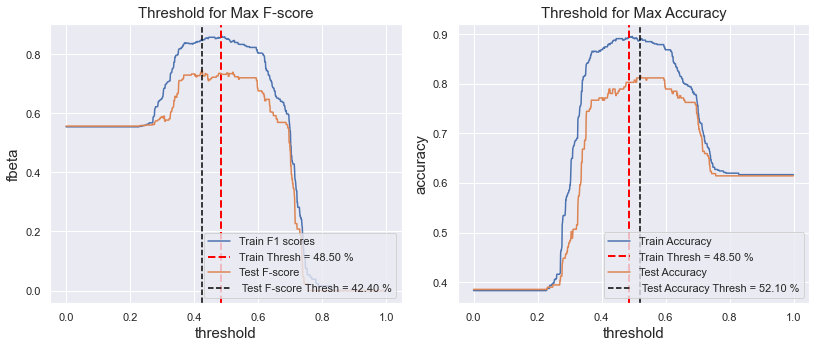

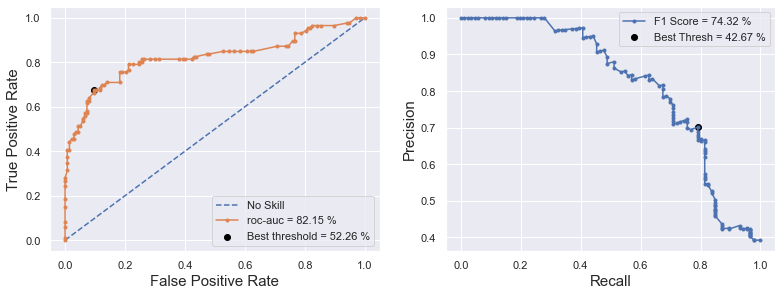

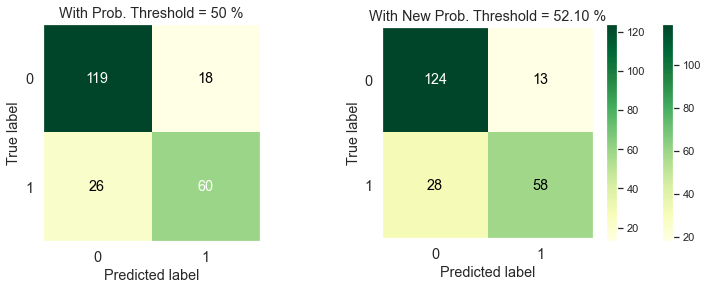

In [30]:
%%time
rgf = RGFClassifier(**rgf_param)

rgf_val = validate_on_test(rgf, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

rgf_val.evaluate_model()

+++++++++++++++
 RGFClassifier 
+++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.556       81.690      88.597  
 2      82.022       77.143      86.058  
 3      84.270       78.125      88.610  
 4      82.022       73.333      86.230  
 5      86.517       81.818      90.508  
 6      86.517       82.353      90.455  
 7      91.011       87.500      93.289  
 8      79.775         70        84.305  
 9      86.517       81.250      91.016  
10      83.146       76.190      86.925  

Progress: [####################################################################################################]1000/1000 100.00%

*** RGFClassifier Mean CV Scores ***
ROC AUC   : 88.599 ± 2.6 %
f1        : 78.940 ± 4.8 %
Accuracy  : 84.735 ± 3.0 %

------------------------------------------------------------------------------------------------------------------------


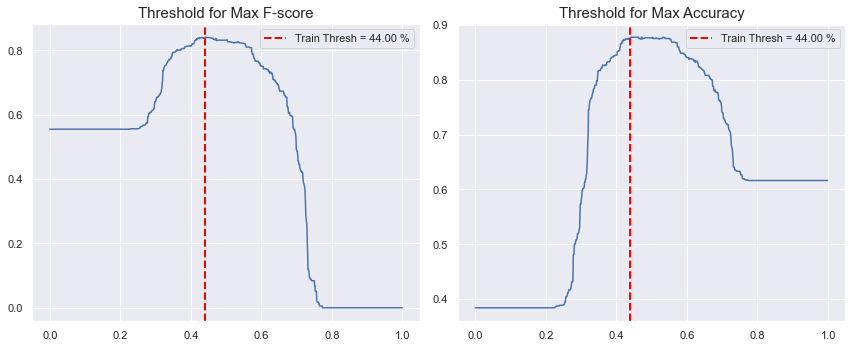

In [33]:
%%time

rgf_pred = predict_unseen_data(rgf, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.44)

rgf_pred.prediction()

sub.Survived = rgf_pred.final_pred
sub.to_csv('new_rgf_1.csv', index = False)

#score =  75.8 %

# XGBoost

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [11:55<00:00,  5.96s/trial, best loss: -0.8027119587890661]

Best Params: {'base_score': 0.39082554104914513, 'booster': 0, 'colsample_bylevel': 0.6044457162836602, 'colsample_bynode': 0.519899279334705, 'colsample_bytree': 0.6541617895263185, 'gamma': 0.01775068000007035, 'learning_rate': 0.09820603542491528, 'max_delta_step': 0.039125244517202375, 'max_depth': 4.0, 'min_child_weight': 1.0, 'n_estimators': 575.0, 'reg_alpha': 0.8265642001676727, 'reg_lambda': 5.96801358633582, 'subsample': 0.6857291870079492}

Wall time: 11min 55s


Text(0.5, 1.0, 'TPE Search')

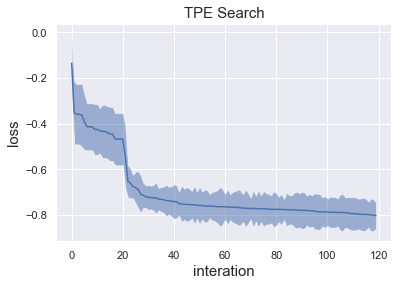

In [34]:
%%time
# hp: define the hyperparameter space
# fmin: optimization function
# Trials: to evaluate the different searched hyperparameters
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, Trials

# the search algorithms
from hyperopt import rand, anneal, tpe

# for the search
from hyperopt import STATUS_OK, STATUS_FAIL
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': hp.quniform('n_estimators', 10, 2500, 25),
    'max_depth': hp.quniform('max_depth', 1, 7, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1)),
    'booster': hp.choice('booster', ['gbtree', 'dart', 'gblinear']),
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(10)),
    'subsample': hp.uniform('subsample', 0.50, 0.90),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.50, 0.99),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.50, 0.99),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.50, 0.99),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(20)), 
    'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1), 
    'base_score': hp.uniform('base_score', 0.3, 0.65), 
    'max_delta_step':  hp.loguniform('max_delta_step', np.log(0.01), np.log(10)), 
    'reg_alpha': hp.uniform('reg_alpha', 0.0001, 2.0)
}

#Defining Objective Function

def objective(params):

    # we need a dictionary to indicate which value from the space
    # to attribute to each value of the hyperparameter in the xgb
    params_dict = {
        # important int, as it takes integers only
        'n_estimators': int(params['n_estimators']),
        # important int, as it takes integers only
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'booster': params['booster'],
        'gamma': params['gamma'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'colsample_bylevel': params['colsample_bylevel'],
        'colsample_bynode': params['colsample_bynode'],
        'random_state': seed,
        'reg_lambda': int(params['reg_lambda']), 
        'min_child_weight': int(params['min_child_weight']),
        'base_score': params['base_score'], 
        'max_delta_step': int(params['max_delta_step']), 
        'reg_lambda': int(params['reg_lambda'])
    }

    # with ** we pass the items in the dictionary as parameters
    # to the xgb
    model = XGBClassifier(**params_dict)

    # train with cv
    cross_val_data = cross_val_score(
        model, 
        X_train_pars, 
        y_train,
        scoring='f1', 
        cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle=True), 
        n_jobs=-1,
    )
    
    
    # === IMPORTANT ===
    # data to be returned by the search, we can add as much as we want
    
    loss = -cross_val_data.mean()
    loss_variance = cross_val_data.std()
    
    try:
        return {
            'loss': loss,
            'loss_variance':loss_variance,
            'status': STATUS_OK,
            }
    except Exception as e:
        return {
            'exception': str(e),
            'status': STATUS_FAIL,
            }


trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=120,
    rstate=np.random.RandomState(seed),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

print()
print(f'Best Params: {tpe_search}')
print()

#Plots
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

ax = sns.lineplot(x='index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('TPE Search')

In [35]:
#To pass as dictionary

def create_param_grid(search, booster): #Here, booster represents the cateogircal parameter.
    best_hp_dict = {
        'n_estimators': int(search['n_estimators']),
        # important int, as it takes integers only
        'max_depth': int(search['max_depth']),
        'learning_rate': search['learning_rate'],
        'booster': booster,
        'gamma': search['gamma'],
        'subsample': search['subsample'],
        'colsample_bytree': search['colsample_bytree'],
        'colsample_bylevel': search['colsample_bylevel'],
        'colsample_bynode': search['colsample_bynode'],
        'random_state': seed,
        'reg_lambda': int(search['reg_lambda']), 
        'min_child_weight': int(search['min_child_weight']),
        'base_score': search['base_score'], 
        'max_delta_step': int(search['max_delta_step']), 
        'reg_lambda': int(search['reg_lambda'])
    }
    return best_hp_dict

xgb_param = create_param_grid(tpe_search, 'gbtree')
print(xgb_param)

{'n_estimators': 575, 'max_depth': 4, 'learning_rate': 0.09820603542491528, 'booster': 'gbtree', 'gamma': 0.01775068000007035, 'subsample': 0.6857291870079492, 'colsample_bytree': 0.6541617895263185, 'colsample_bylevel': 0.6044457162836602, 'colsample_bynode': 0.519899279334705, 'random_state': 42, 'reg_lambda': 5, 'min_child_weight': 1, 'base_score': 0.39082554104914513, 'max_delta_step': 0}


+++++++++++++++
 XGBClassifier 
+++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.075         80        92.917  
 2      88.060       83.333      86.773  
 3      92.537       90.196      90.947  
 4      82.090         75        80.722  
 5      82.090       73.913      91.041  
 6      83.582         80        91.839  
 7      80.597       72.340      80.905  
 8      91.045         88        95.190  
 9      87.879       83.333      88.488  
10      83.333       76.596        90    

*** XGBClassifier Mean CV Scores ***
ROC AUC   : 88.882 ± 4.6 %
f1        : 80.271 ± 5.7 %
Accuracy  : 85.629 ± 3.8 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           0       0.83      0.88      

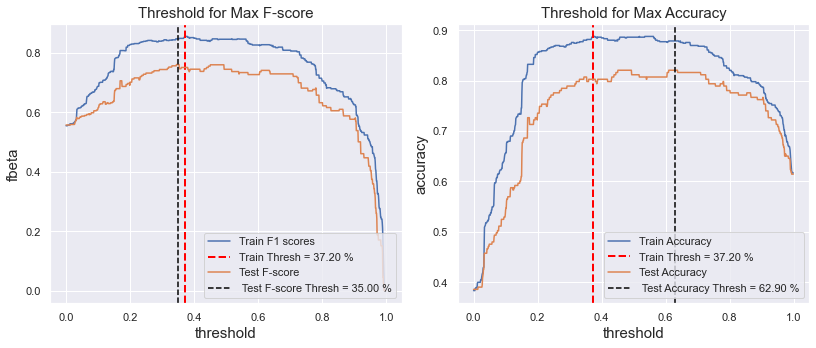

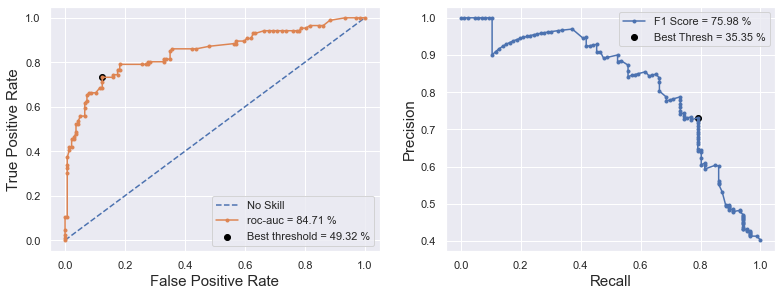

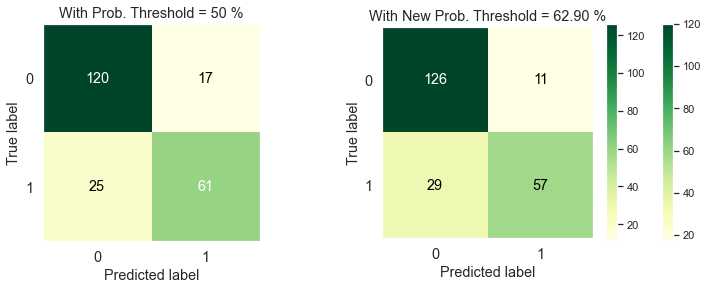

In [41]:
%%time
xgb = XGBClassifier(use_label_encoder=False, eval_metric = 'error', **xgb_param) 

xgb_val = validate_on_test(xgb, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

xgb_val.evaluate_model()

+++++++++++++++
 XGBClassifier 
+++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      85.556       82.192      87.584  
 2      85.393       81.159      87.169  
 3      84.270       78.125      89.278  
 4      82.022       73.333      85.455  
 5      87.640       83.582      91.070  
 6      84.270         80        90.535  
 7      91.011       87.500      92.139  
 8      80.899       72.131      85.160  
 9      85.393         80        90.374  
10      83.146       76.190      86.417  

Progress: [####################################################################################################]1000/1000 100.00%

*** XGBClassifier Mean CV Scores ***
ROC AUC   : 88.518 ± 2.4 %
f1        : 79.421 ± 4.4 %
Accuracy  : 84.960 ± 2.7 %

------------------------------------------------------------------------------------------------------------------------


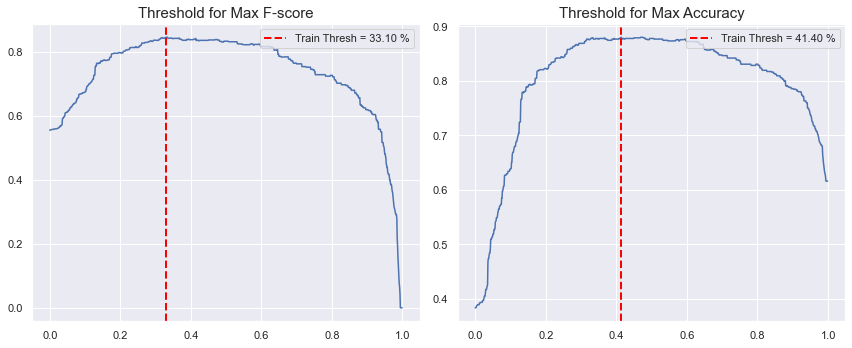

In [43]:
%%time

xgb_pred = predict_unseen_data(xgb, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.4140)

xgb_pred.prediction()

sub.Survived = xgb_pred.final_pred
sub.to_csv('new_xgb_1.csv', index = False)

#score =  75.8 %

# ExtraTrees

++++++++++++++++++++++
 ExtraTreesClassifier 
++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      86.567       83.636      93.996  
 2      86.567       83.019      88.180  
 3      88.060       85.185      90.244  
 4      77.612       70.588      83.443  
 5      85.075         80        91.229  
 6      82.090       79.310      90.619  
 7      82.090         76        80.476  
 8      91.045       88.889      94.762  
 9      75.758       71.429      84.976  
10      84.848         80        88.439  

*** ExtraTreesClassifier Mean CV Scores ***
ROC AUC   : 88.636 ± 4.3 %
f1        : 79.806 ± 5.5 %
Accuracy  : 83.971 ± 4.4 %

------------------------------------------------------------------------------------------------------------------------

Classification report on Test set:

              precision    recall  f1-score   support

           

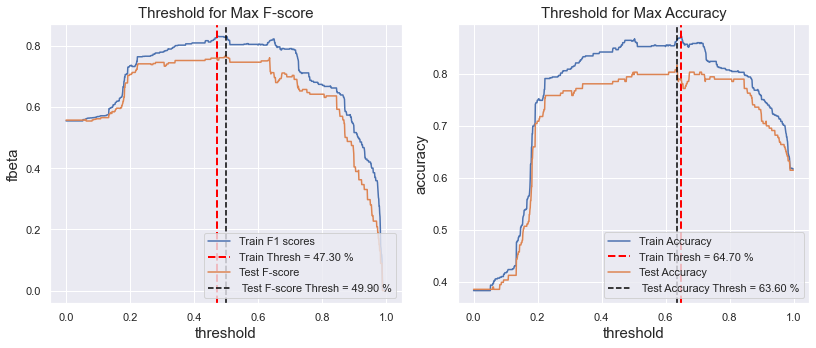

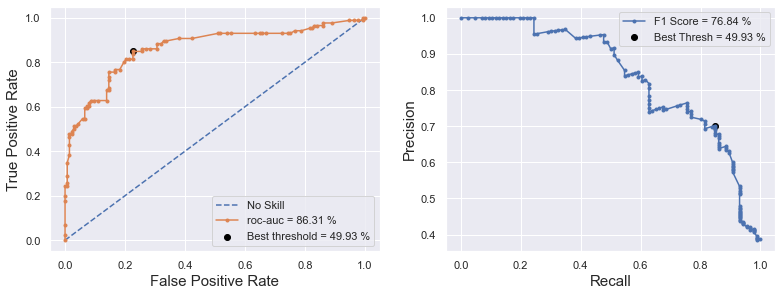

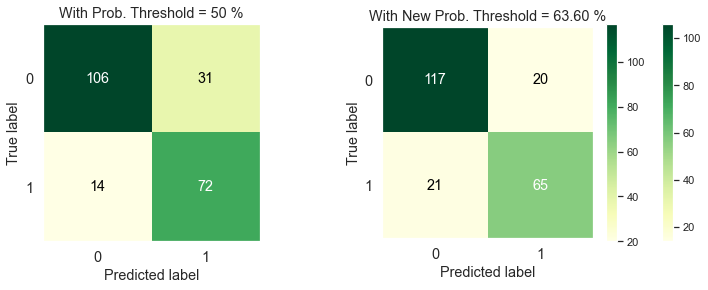

In [44]:
%%time
et = ExtraTreesClassifier(criterion='entropy', max_depth=6, class_weight='balanced', 
                          n_jobs=-1, random_state = seed)

et_val = validate_on_test(et, 
                          X_train_pars, 
                          y_train, 
                          X_test_pars, 
                          y_test, 
                          cv = skf, 
                          beta = 'auto', 
                          optimize = 'accuracy')

et_val.evaluate_model()

++++++++++++++++++++++
 ExtraTreesClassifier 
++++++++++++++++++++++

Performing Cross-Validation...
------------------------------------------
CV# | Accuracy % | f1 Score % | ROC-AUC %
------------------------------------------
 1      81.111       77.333      88.831  
 2      78.652       73.239      86.640  
 3      77.528       71.429      87.353  
 4      77.528       68.750      84.759  
 5      86.517       82.353      91.283  
 6      84.270       80.556      88.155  
 7      86.517       82.857      90.882  
 8      80.899       73.846      86.310  
 9      83.146       79.452      91.711  
10      79.775       72.727      88.824  

Progress: [####################################################################################################]1000/1000 100.00%

*** ExtraTreesClassifier Mean CV Scores ***
ROC AUC   : 88.475 ± 2.2 %
f1        : 76.254 ± 4.7 %
Accuracy  : 81.594 ± 3.2 %

---------------------------------------------------------------------------------------------

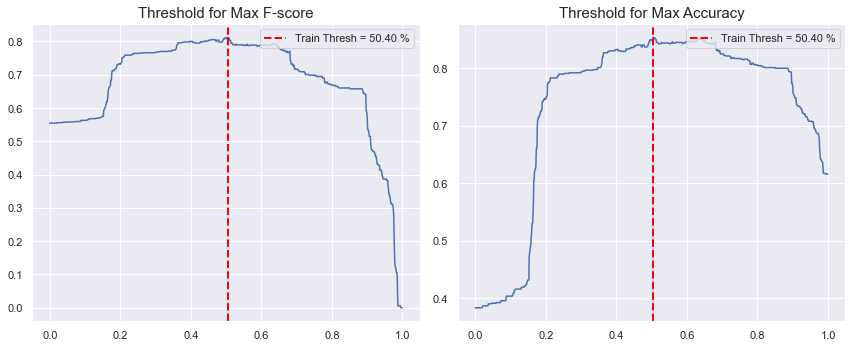

In [46]:
%%time

et_pred = predict_unseen_data(et, 
                              train, 
                              target, 
                              TEST_DF_pars, 
                              cv = skf, 
                              set_threshold=0.64)

et_pred.prediction()

sub.Survived = et_pred.final_pred
sub.to_csv('new_et_1.csv', index = False)

#score =  77.5 %